# Listwise

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
from models.dialogue import UtteranceTransformerDMConfig, UtteranceTransformerDM
from models.listwise import DecoderUtteranceSorter, Decoder


head_dropout_prob = 0.02
encoder_name = 'sentence-transformers/all-mpnet-base-v2'
config = UtteranceTransformerDMConfig(
    num_attention_heads=4,
    attention_probs_dropout_prob=0.02,
    n_layers=4,
    encoder_name=encoder_name,
    embed_turn_ids=False,
    is_casual=False
)
_dialogue_model = UtteranceTransformerDM(config)

_model = DecoderUtteranceSorter(
    dialogue_model=_dialogue_model,
    dropout_prob=head_dropout_prob,
    max_n_uts=20,
    decoder=Decoder(top_k=2)
)

model = DecoderUtteranceSorter.from_checkpoint(
    path_to_ckpt='/home/alekseev_ilya/dialogue-augmentation/nup/logs/training/listwise-decoder/checkpoints/last.ckpt',
    model=_model,
    map_location='cuda'
)

/home/alekseev_ilya/dialogue-augmentation/VENV/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Score vs Shuffling

In [4]:
import json

n_dialogues = 128
dataset = json.load(open('/home/alekseev_ilya/dialogue-augmentation/nup/dialogues/val/0.json', 'r'))[:n_dialogues]

In [5]:
non_reducted, geo_mean, arith_mean = model.score(batch=dataset)

In [6]:
len(arith_mean), len(geo_mean), len(non_reducted), len(non_reducted[1])

(128, 128, 128, 16)

In [7]:
import numpy as np
from tqdm.autonotebook import tqdm
import math
from collections import defaultdict
import pandas as pd

def random_swap(arr, n_swaps):
    """n_swaps must be bounded by len(arr) / 2"""
    arr = arr[:]
    idx_pairs = np.random.choice(len(arr), (n_swaps, 2), replace=False)
    for i, j in idx_pairs:
        arr[i], arr[j] = arr[j], arr[i]
    return arr

grid_size = 11
fraction_swaps_list = np.linspace(0, 1, grid_size)
df_list = []
for frac in tqdm(fraction_swaps_list):
    shuffled_dataset = []
    for dia in dataset:
        n_swaps = math.ceil(frac * (len(dia) // 2))
        shuffled_dataset.append(random_swap(dia, n_swaps))
    non_reducted, geo_mean, arith_mean = model.score(batch=shuffled_dataset)
    df_list.append(pd.DataFrame({
        'frac': frac,
        'geo_mean': geo_mean,
        'arith_mean': arith_mean,
        'min': [np.min(probs) for probs in non_reducted],
        'max': [np.max(probs) for probs in non_reducted]
    }))

100%|██████████| 11/11 [00:35<00:00,  3.23s/it]


In [8]:
df = pd.concat(df_list, axis=0)

<Axes: xlabel='frac', ylabel='arith_mean'>

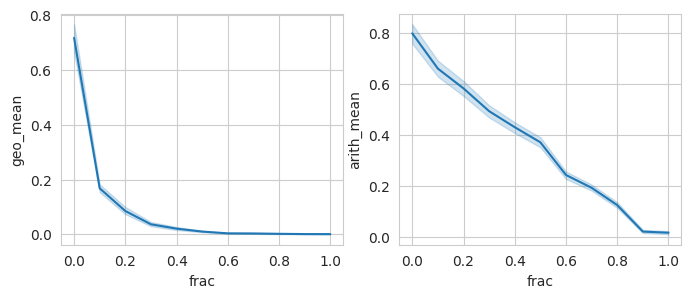

In [9]:
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
sns.lineplot(data=df, x='frac', y='geo_mean', ax=ax[0])
sns.lineplot(data=df, x='frac', y='arith_mean', ax=ax[1])

- арифметическое среднее жесть как хорошо отражает степень перемешанности
- надо попробовать ариф среднее для пейрвайс, потому что там я считал только геом

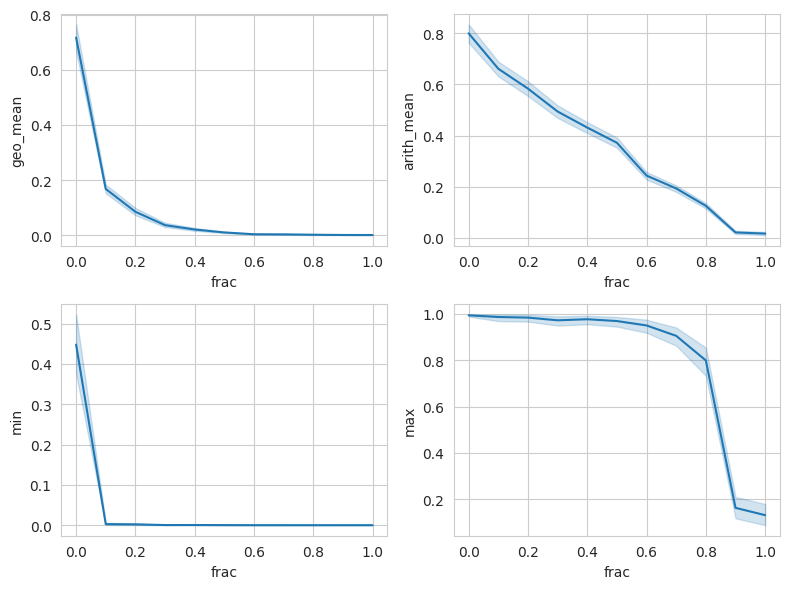

In [10]:
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt


fig, ax = plt.subplots(2, 2, figsize=(8, 6))

sns.lineplot(data=df, x='frac', y='geo_mean', ax=ax[0, 0])
sns.lineplot(data=df, x='frac', y='arith_mean', ax=ax[0, 1])
sns.lineplot(data=df, x='frac', y='min',  ax=ax[1, 0])
sns.lineplot(data=df, x='frac', y='max',  ax=ax[1, 1])
plt.tight_layout()

- хорошо что минимальная вероятность так сильно проседает т.к. это отражает наличие неправильного шаффла
- плохо что максимальная вероятность так слабо проседает т.к. это должно отражать наличие неправильного шаффла
    - надо конечно еще исследовать какие уттерансы вносят вклад в этот максимум
    - но пока есть гипотеза что это из-за переобучения под конкретные позиции в диалоге?

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


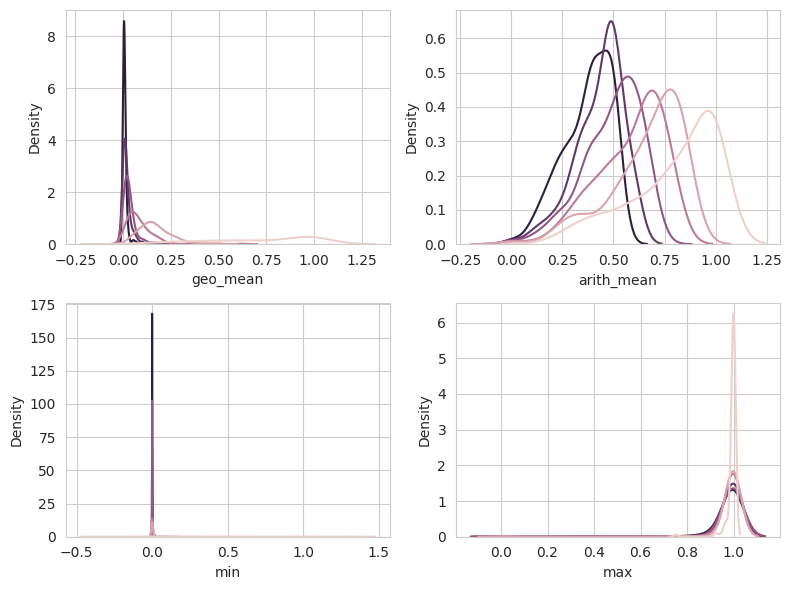

In [11]:
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt


fig, ax = plt.subplots(2, 2, figsize=(8, 6))

df_f = df[df.frac <= 0.5]
sns.kdeplot(data=df_f, hue='frac', x='geo_mean', ax=ax[0, 0])
sns.kdeplot(data=df_f, hue='frac', x='arith_mean', ax=ax[0, 1])
sns.kdeplot(data=df_f, hue='frac', x='min',  ax=ax[1, 0])
sns.kdeplot(data=df_f, hue='frac', x='max',  ax=ax[1, 1])

for a in ax.flatten():
    a.legend(frameon=False)

plt.tight_layout()

- хорошо что на сильно зашафленных диалогах показывает такой малый скор
- хорошо что на незашафленных диалогах показывает умеренный скор (а не завышенный), это показывает что есть пространство для шаффлов и катов
- плохо что максимум так высок даже на зашафленных диалогах

пришла идея как придумывать аугментации на подобие CLM:
- на каждой позиции выбирать тот уттеранс, вероятность которого быть на данной позиции максимально (жадный декодинг)
- и так далее по аналогии: beam search, top-k, nuclear

## Score vs Position

In [48]:
import json

dataset = json.load(open('../aug-data/original.json', 'r'))
dataset = [dia for dia in dataset if len(dia) <= 20]

In [49]:
[len(dia) for dia in dataset]

[12, 20, 6, 12, 20, 12, 16, 16, 16, 8, 18, 12, 18]

In [50]:
all_scores, _, _ = model.score(batch=dataset)

In [51]:
len(all_scores)

13

In [52]:
import pandas as pd
import numpy as np

df_list = []
for i_dia, scores in enumerate(all_scores):
    df_list.append(pd.DataFrame({
        'i_dia': i_dia,
        'i_pair': np.arange(len(scores)-1),
        'score': scores[1:]
    }))
df = pd.concat(df_list, axis=0)

In [55]:
def show_positionwise_scores(i_dia):
    speaker_alias = "AB"
    dia = dataset[i_dia]
    scores = [1] + df[df.i_dia == i_dia].sort_values('i_pair')['score'].tolist()
    uts = [f'[{speaker_alias[item["speaker"]]}] [score: {score:5.2f}] {item["utterance"]}' for score, item in zip(scores, dia)]
    print('\n'.join(uts))

[A] [score:  1.00] I need a train from birmingham new street to cambridge, please.
[B] [score:  0.38] There are 133 trains traveling that path. What day would you like to travel on?
[A] [score:  0.27] I would like to leave on Wednesday sometime after 11:30.
[B] [score:  0.33] How about the TR1670? It meets your specifications and leaves at 11:40.
[A] [score:  0.07] How long is the train ride?
[B] [score:  0.09] The train ride is 163 minutes, does this suit your needs?
[A] [score:  0.14] How much is the fare on that train?
[B] [score:  0.08] It is 75.10 pounds.
[A] [score:  0.23] What is the exact arrival time? I'm also looking for a place to dine in the centre of town. I'm looking for an expensive modern european restaurant.
[B] [score:  0.30] Let's take care of the train first. The train will arrive by 14:23 in Cambridge. Would you like to book a ticket?
[A] [score:  0.26] Thank you I do not need to book the train, but I am looking for an expensive restaurant in the centre of town.
[B

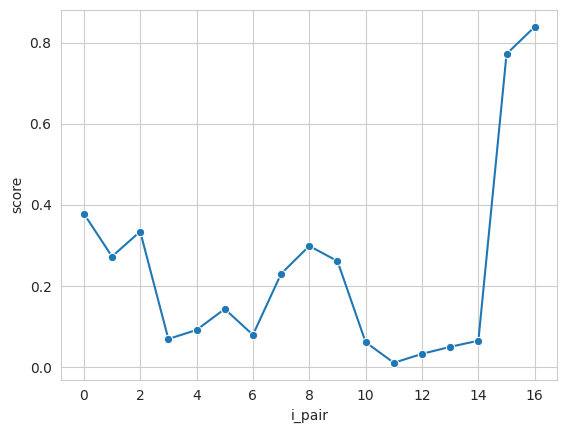

In [56]:
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

i_dia = 12
show_positionwise_scores(i_dia)
# sns.lineplot(data=df[df.i_dia==i_dia], x='i_pair', y='rel_score', marker='o')
sns.lineplot(data=df[df.i_dia==i_dia], x='i_pair', y='score', marker='o')
plt.show()

модель требует переработки:
- скоры высокие у последней и первой фраз в диалоге, все остальные фразы имеют очень маленький скор
- мейби обучение в CLM-стиле исправит это

## Checking Hypothesis

In [57]:
import json

segments = json.load(open('segments.json', 'r'))
segments_precise = json.load(open('segments_precise.json', 'r'))

segments = [seg for seg in segments if len(seg) <= 20]
segments_precise = [seg for seg in segments_precise if len(seg) <= 20]

In [58]:
def is_switch(lab1, lab2):
    a = lab1 != lab2
    b = isinstance(lab1, list) or isinstance(lab2, list)
    return a or b
scores_list = []
i_pair_list = []
is_switch_list = []
is_switch_precise_list = []
i_dia_list = []
for i_dia in range(len(dataset)):
    df_tmp = df[df.i_dia == i_dia].sort_values('i_pair')
    scores = df_tmp['score'].tolist()
    scores_list.extend(scores)
    # print(len(scores), len(segments))
    for i in range(len(scores)):
        is_switch_list.append(is_switch(segments[i_dia][i], segments[i_dia][i+1]))
        is_switch_precise_list.append(is_switch(segments_precise[i_dia][i], segments_precise[i_dia][i+1]))
    i_pair_list.extend(list(range(len(scores))))
    i_dia_list.extend([i_dia] * len(scores))
    

df_switch = pd.DataFrame({
    'score': scores_list,
    'i_pair': i_pair_list,
    'i_dia': i_dia_list,
    'is_switch': is_switch_list,
    'is_switch_precise': is_switch_precise_list
})

In [64]:
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score


def draw_switch(df):
    x = 'score'
    
    fig, ax = plt.subplots(2, 2, figsize=(10, 6))
    sns.kdeplot(df, x=x, hue='is_switch', ax=ax[0,1])
    sns.scatterplot(df, x=x, y='is_switch', hue='is_switch', ax=ax[0,0])
    sns.kdeplot(df, x=x, hue='is_switch_precise', ax=ax[1,1])
    sns.scatterplot(df, x=x, y='is_switch_precise', hue='is_switch_precise', ax=ax[1,0])
    ax[0,0].get_legend().remove()
    ax[1,0].get_legend().remove()
    clf_score = average_precision_score(df['is_switch'], -df[x])
    clf_score_precise = average_precision_score(df['is_switch_precise'], -df[x])
    print('is_switch clf metric:', clf_score)
    print('is_switch_precise clf metric:', clf_score_precise)
    plt.tight_layout()
    plt.show()

is_switch clf metric: 0.18277484601270194
is_switch_precise clf metric: 0.4750267829370144


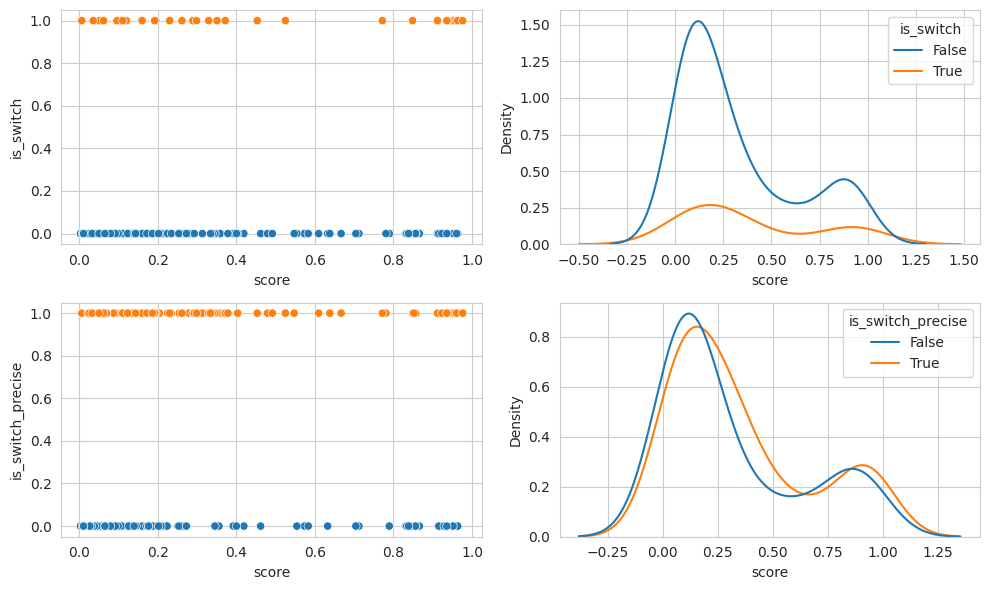

In [65]:
draw_switch(df_switch)

is_switch clf metric: 0.2685839160839161
is_switch_precise clf metric: 0.6352419045600863


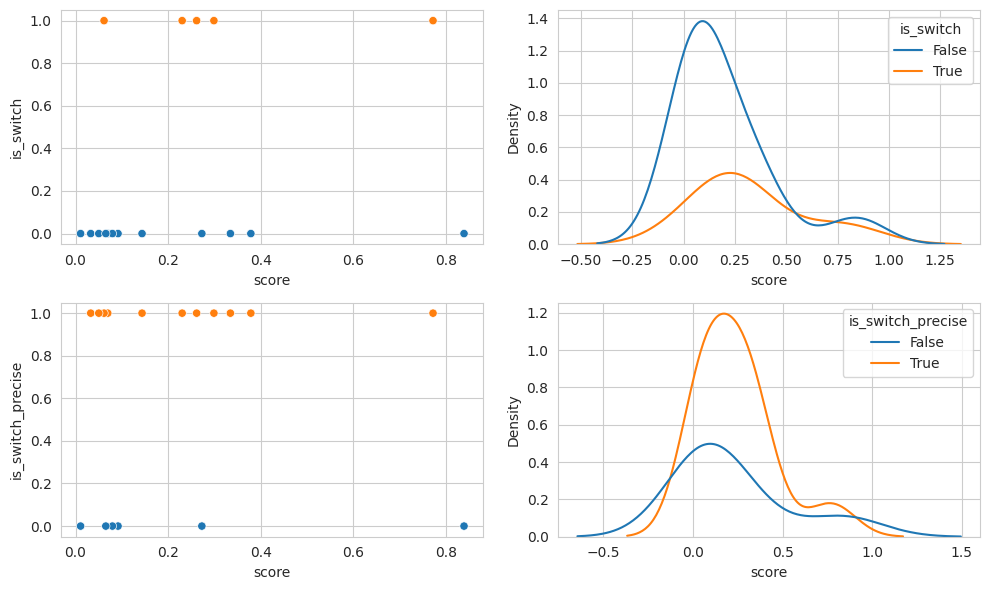

In [80]:
i_dia = 12
draw_switch(df_switch[df_switch.i_dia == i_dia])

In [84]:
def compute_clf_metrics(df, target_name, score_name):
    res = []
    for i_dia in range(13):
        df_ = df[df.i_dia == i_dia]
        res.append(average_precision_score(df_[target_name], -df_[score_name]))
    return res

In [85]:
clf_metrics = compute_clf_metrics(df_switch, 'is_switch', 'score')
clf_metrics_precise = compute_clf_metrics(df_switch, 'is_switch_precise', 'score')

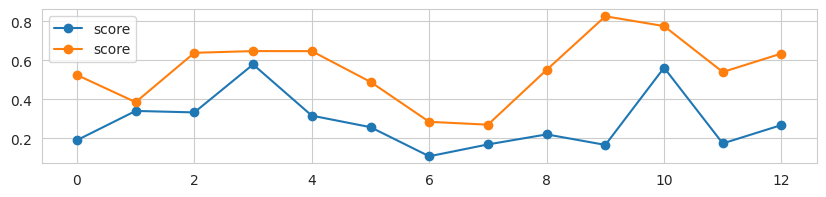

In [87]:
plt.figure(figsize=(10,2))
x = range(15)
plt.plot(clf_metrics, label='score', marker='o')
plt.plot(clf_metrics_precise, label='score', marker='o')
plt.legend()

## Augmentation demo

In [5]:
import json

dataset = json.load(open('../aug-data/original.json', 'r'))

In [25]:
from models.listwise import Decoder

decoder = Decoder()
augmented = model.augment(dataset, decoder)

In [26]:
[len(dia) for dia in dataset]

[12, 20, 6, 12, 20, 12, 16, 16, 28, 16, 26, 8, 18, 12, 18]

In [27]:
[len(dia) for dia in augmented]

[12, 20, 6, 12, 20, 12, 16, 16, 20, 16, 20, 8, 18, 12, 18]

In [28]:
from difflib import HtmlDiff
import html2markdown
from IPython.display import Markdown, display

def parse(dia):
    speaker_alias = "AB"
    return [f'[{speaker_alias[dia[i_ut]["speaker"]]}] {dia[i_ut]["utterance"]}' for i_ut in range(len(dia))]


def show_shuffling(orig, shuffled):
    orig = parse(orig)
    aug = parse(shuffled)
    raw = HtmlDiff(wrapcolumn=70).make_table(orig, aug)
    raw = html2markdown.convert(raw)
    display(Markdown(raw))

In [29]:
i_dia = 0
show_shuffling(dataset[i_dia], augmented[i_dia])

<table cellpadding="0" cellspacing="0" class="diff" id="difflib_chg_to3__top" rules="groups">
<colgroup></colgroup> <colgroup></colgroup> <colgroup></colgroup>
<colgroup></colgroup> <colgroup></colgroup> <colgroup></colgroup>
<tbody>
<tr><td class="diff_next" id="difflib_chg_to3__0"><a href="#difflib_chg_to3__0">f</a></td><td class="diff_header" id="from3_1">1</td><td nowrap="nowrap">[A]&nbsp;I'm&nbsp;looking&nbsp;for&nbsp;a&nbsp;local&nbsp;place&nbsp;to&nbsp;dine&nbsp;in&nbsp;the&nbsp;centre&nbsp;that&nbsp;serves&nbsp;ch</td><td class="diff_next"><a href="#difflib_chg_to3__0">f</a></td><td class="diff_header" id="to3_1">1</td><td nowrap="nowrap">[A]&nbsp;I'm&nbsp;looking&nbsp;for&nbsp;a&nbsp;local&nbsp;place&nbsp;to&nbsp;dine&nbsp;in&nbsp;the&nbsp;centre&nbsp;that&nbsp;serves&nbsp;ch</td></tr>
<tr><td class="diff_next"></td><td class="diff_header">&gt;</td><td nowrap="nowrap">inese&nbsp;food.</td><td class="diff_next"></td><td class="diff_header">&gt;</td><td nowrap="nowrap">inese&nbsp;food.</td></tr>
<tr><td class="diff_next"></td><td class="diff_header" id="from3_2">2</td><td nowrap="nowrap">[B]&nbsp;I&nbsp;have&nbsp;restaurants&nbsp;matching&nbsp;your&nbsp;criteria&nbsp;in&nbsp;all&nbsp;price&nbsp;ranges.&nbsp;Do&nbsp;</td><td class="diff_next"></td><td class="diff_header" id="to3_2">2</td><td nowrap="nowrap">[B]&nbsp;I&nbsp;have&nbsp;restaurants&nbsp;matching&nbsp;your&nbsp;criteria&nbsp;in&nbsp;all&nbsp;price&nbsp;ranges.&nbsp;Do&nbsp;</td></tr>
<tr><td class="diff_next"></td><td class="diff_header">&gt;</td><td nowrap="nowrap">you&nbsp;have&nbsp;a&nbsp;preference&nbsp;on&nbsp;price?</td><td class="diff_next"></td><td class="diff_header">&gt;</td><td nowrap="nowrap">you&nbsp;have&nbsp;a&nbsp;preference&nbsp;on&nbsp;price?</td></tr>
<tr><td class="diff_next"><a href="#difflib_chg_to3__1">n</a></td><td class="diff_header" id="from3_3">3</td><td nowrap="nowrap"><span class="diff_sub">[A]&nbsp;I&nbsp;need&nbsp;the&nbsp;address,&nbsp;postcode&nbsp;and&nbsp;the&nbsp;price&nbsp;range.</span></td><td class="diff_next"><a href="#difflib_chg_to3__1">n</a></td><td class="diff_header"></td><td nowrap="nowrap"></td></tr>
<tr><td class="diff_next"></td><td class="diff_header" id="from3_4">4</td><td nowrap="nowrap"><span class="diff_sub">[B]&nbsp;Ok&nbsp;how&nbsp;about&nbsp;Charlie&nbsp;Chan,&nbsp;located&nbsp;at&nbsp;Regent&nbsp;Street&nbsp;City&nbsp;Centre.&nbsp;P</span></td><td class="diff_next"></td><td class="diff_header"></td><td nowrap="nowrap"></td></tr>
<tr><td class="diff_next"></td><td class="diff_header">&gt;</td><td nowrap="nowrap"><span class="diff_sub">ostcode&nbsp;is&nbsp;cb21db&nbsp;with&nbsp;a&nbsp;cheap&nbsp;price.&nbsp;Can&nbsp;I&nbsp;help&nbsp;you&nbsp;further&nbsp;today?</span></td><td class="diff_next"></td><td class="diff_header"></td><td nowrap="nowrap">&nbsp;</td></tr>
<tr><td class="diff_next"></td><td class="diff_header" id="from3_5">5</td><td nowrap="nowrap"><span class="diff_sub">[A]&nbsp;I&nbsp;also&nbsp;need&nbsp;a&nbsp;train.&nbsp;The&nbsp;train&nbsp;should&nbsp;leave&nbsp;after&nbsp;16:15&nbsp;and&nbsp;should</span></td><td class="diff_next"></td><td class="diff_header"></td><td nowrap="nowrap"></td></tr>
<tr><td class="diff_next" id="difflib_chg_to3__1"></td><td class="diff_header">&gt;</td><td nowrap="nowrap"><span class="diff_sub">&nbsp;leave&nbsp;on&nbsp;sunday.</span></td><td class="diff_next"></td><td class="diff_header"></td><td nowrap="nowrap">&nbsp;</td></tr>
<tr><td class="diff_next"></td><td class="diff_header" id="from3_6">6</td><td nowrap="nowrap"><span class="diff_sub">[B]&nbsp;Can&nbsp;I&nbsp;have&nbsp;more&nbsp;information&nbsp;for&nbsp;the&nbsp;train&nbsp;you're&nbsp;needing?&nbsp;Where&nbsp;ar</span></td><td class="diff_next"></td><td class="diff_header"></td><td nowrap="nowrap"></td></tr>
<tr><td class="diff_next"></td><td class="diff_header">&gt;</td><td nowrap="nowrap"><span class="diff_sub">e&nbsp;you&nbsp;departing&nbsp;from&nbsp;and&nbsp;arriving&nbsp;to?</span></td><td class="diff_next"></td><td class="diff_header"></td><td nowrap="nowrap">&nbsp;</td></tr>
<tr><td class="diff_next"></td><td class="diff_header" id="from3_7">7</td><td nowrap="nowrap">[A]&nbsp;I&nbsp;am&nbsp;leaving&nbsp;from&nbsp;Cambridge&nbsp;and&nbsp;going&nbsp;to&nbsp;Norwich.</td><td class="diff_next"></td><td class="diff_header" id="to3_3">3</td><td nowrap="nowrap">[A]&nbsp;I&nbsp;am&nbsp;leaving&nbsp;from&nbsp;Cambridge&nbsp;and&nbsp;going&nbsp;to&nbsp;Norwich.</td></tr>
<tr><td class="diff_next"></td><td class="diff_header" id="from3_8">8</td><td nowrap="nowrap">[B]&nbsp;I&nbsp;have&nbsp;train&nbsp;TR1840&nbsp;leaving&nbsp;at&nbsp;16:36&nbsp;is&nbsp;that&nbsp;okay?</td><td class="diff_next"></td><td class="diff_header" id="to3_4">4</td><td nowrap="nowrap">[B]&nbsp;I&nbsp;have&nbsp;train&nbsp;TR1840&nbsp;leaving&nbsp;at&nbsp;16:36&nbsp;is&nbsp;that&nbsp;okay?</td></tr>
<tr><td class="diff_next"><a href="#difflib_chg_to3__2">n</a></td><td class="diff_header"></td><td nowrap="nowrap"></td><td class="diff_next"><a href="#difflib_chg_to3__2">n</a></td><td class="diff_header" id="to3_5">5</td><td nowrap="nowrap"><span class="diff_add">[A]&nbsp;I&nbsp;also&nbsp;need&nbsp;a&nbsp;train.&nbsp;The&nbsp;train&nbsp;should&nbsp;leave&nbsp;after&nbsp;16:15&nbsp;and&nbsp;should</span></td></tr>
<tr><td class="diff_next"></td><td class="diff_header"></td><td nowrap="nowrap">&nbsp;</td><td class="diff_next"></td><td class="diff_header">&gt;</td><td nowrap="nowrap"><span class="diff_add">&nbsp;leave&nbsp;on&nbsp;sunday.</span></td></tr>
<tr><td class="diff_next" id="difflib_chg_to3__2"></td><td class="diff_header"></td><td nowrap="nowrap"></td><td class="diff_next"></td><td class="diff_header" id="to3_6">6</td><td nowrap="nowrap"><span class="diff_add">[B]&nbsp;Ok&nbsp;how&nbsp;about&nbsp;Charlie&nbsp;Chan,&nbsp;located&nbsp;at&nbsp;Regent&nbsp;Street&nbsp;City&nbsp;Centre.&nbsp;P</span></td></tr>
<tr><td class="diff_next"></td><td class="diff_header"></td><td nowrap="nowrap">&nbsp;</td><td class="diff_next"></td><td class="diff_header">&gt;</td><td nowrap="nowrap"><span class="diff_add">ostcode&nbsp;is&nbsp;cb21db&nbsp;with&nbsp;a&nbsp;cheap&nbsp;price.&nbsp;Can&nbsp;I&nbsp;help&nbsp;you&nbsp;further&nbsp;today?</span></td></tr>
<tr><td class="diff_next"></td><td class="diff_header" id="from3_9">9</td><td nowrap="nowrap">[A]&nbsp;book&nbsp;for&nbsp;5&nbsp;people&nbsp;and&nbsp;get&nbsp;me&nbsp;the&nbsp;reference&nbsp;number</td><td class="diff_next"></td><td class="diff_header" id="to3_7">7</td><td nowrap="nowrap">[A]&nbsp;book&nbsp;for&nbsp;5&nbsp;people&nbsp;and&nbsp;get&nbsp;me&nbsp;the&nbsp;reference&nbsp;number</td></tr>
<tr><td class="diff_next"></td><td class="diff_header" id="from3_10">10</td><td nowrap="nowrap">[B]&nbsp;You're&nbsp;all&nbsp;set.&nbsp;Reference&nbsp;number&nbsp;is&nbsp;NJB87PAP&nbsp;.&nbsp;Is&nbsp;there&nbsp;anything&nbsp;e</td><td class="diff_next"></td><td class="diff_header" id="to3_8">8</td><td nowrap="nowrap">[B]&nbsp;You're&nbsp;all&nbsp;set.&nbsp;Reference&nbsp;number&nbsp;is&nbsp;NJB87PAP&nbsp;.&nbsp;Is&nbsp;there&nbsp;anything&nbsp;e</td></tr>
<tr><td class="diff_next"></td><td class="diff_header">&gt;</td><td nowrap="nowrap">lse&nbsp;I&nbsp;can&nbsp;help&nbsp;you&nbsp;with&nbsp;today?</td><td class="diff_next"></td><td class="diff_header">&gt;</td><td nowrap="nowrap">lse&nbsp;I&nbsp;can&nbsp;help&nbsp;you&nbsp;with&nbsp;today?</td></tr>
<tr><td class="diff_next"><a href="#difflib_chg_to3__top">t</a></td><td class="diff_header"></td><td nowrap="nowrap"></td><td class="diff_next"><a href="#difflib_chg_to3__top">t</a></td><td class="diff_header" id="to3_9">9</td><td nowrap="nowrap"><span class="diff_add">[A]&nbsp;I&nbsp;need&nbsp;the&nbsp;address,&nbsp;postcode&nbsp;and&nbsp;the&nbsp;price&nbsp;range.</span></td></tr>
<tr><td class="diff_next"></td><td class="diff_header"></td><td nowrap="nowrap"></td><td class="diff_next"></td><td class="diff_header" id="to3_10">10</td><td nowrap="nowrap"><span class="diff_add">[B]&nbsp;Can&nbsp;I&nbsp;have&nbsp;more&nbsp;information&nbsp;for&nbsp;the&nbsp;train&nbsp;you're&nbsp;needing?&nbsp;Where&nbsp;ar</span></td></tr>
<tr><td class="diff_next"></td><td class="diff_header"></td><td nowrap="nowrap">&nbsp;</td><td class="diff_next"></td><td class="diff_header">&gt;</td><td nowrap="nowrap"><span class="diff_add">e&nbsp;you&nbsp;departing&nbsp;from&nbsp;and&nbsp;arriving&nbsp;to?</span></td></tr>
<tr><td class="diff_next"></td><td class="diff_header" id="from3_11">11</td><td nowrap="nowrap">[A]&nbsp;No,&nbsp;this&nbsp;is&nbsp;all&nbsp;I&nbsp;will&nbsp;need.&nbsp;Thank&nbsp;you.</td><td class="diff_next"></td><td class="diff_header" id="to3_11">11</td><td nowrap="nowrap">[A]&nbsp;No,&nbsp;this&nbsp;is&nbsp;all&nbsp;I&nbsp;will&nbsp;need.&nbsp;Thank&nbsp;you.</td></tr>
<tr><td class="diff_next"></td><td class="diff_header" id="from3_12">12</td><td nowrap="nowrap">[B]&nbsp;Thank&nbsp;for&nbsp;calling&nbsp;us&nbsp;today.&nbsp;I&nbsp;hope&nbsp;you&nbsp;have&nbsp;a&nbsp;good&nbsp;trip.</td><td class="diff_next"></td><td class="diff_header" id="to3_12">12</td><td nowrap="nowrap">[B]&nbsp;Thank&nbsp;for&nbsp;calling&nbsp;us&nbsp;today.&nbsp;I&nbsp;hope&nbsp;you&nbsp;have&nbsp;a&nbsp;good&nbsp;trip.</td></tr>
</tbody>
</table>